# Load Tools

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import shap

In [ ]:
uploads = files.upload()

dataset = list(uploads.keys())[0]

Saving clean_resume_data.csv to clean_resume_data.csv


# Import Clean Dataset

In [ ]:
clean_df = pd.read_csv(dataset)

In [ ]:
clean_df['Category'].value_counts()
print(len(clean_df['Category'].unique()))
clean_df['Category'].value_counts()

24


,count
Category,
INFORMATION-TECHNOLOGY,120
BUSINESS-DEVELOPMENT,120
ADVOCATE,118
CHEF,118
ENGINEERING,118
ACCOUNTANT,118
FINANCE,118
FITNESS,117
AVIATION,117


In [ ]:
clean_df.shape

(2484, 3)

# Exploratory Data analysis

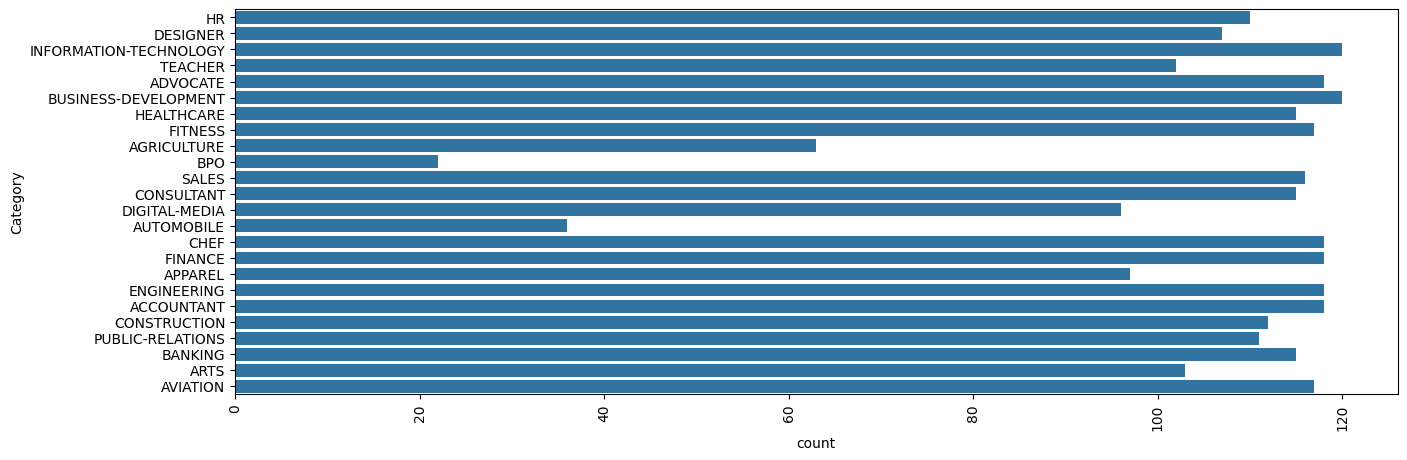

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(clean_df['Category'])
plt.xticks(rotation=90)
plt.show()

Text(0.5, 1.0, 'Category Distribution')

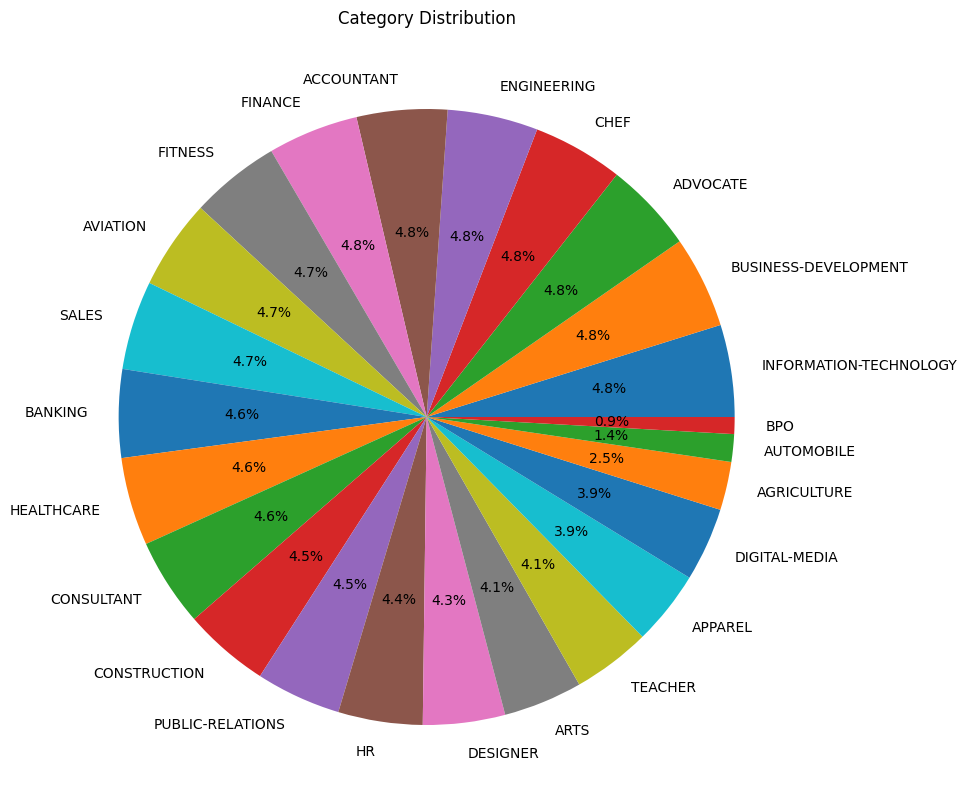

In [ ]:
counts = clean_df['Category'].value_counts()
labels = counts.index  # ensure labels match the sorted counts

# Create pie chart
plt.figure(figsize=(15,10))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Category Distribution')

# Save and download
# filename = 'category_pie_chart.png'
# plt.savefig(filename)
# files.download(filename)


# Balance Dataset

In [ ]:
from sklearn.utils import resample

max_count = clean_df['Category'].value_counts().max()

balanced_data = []
for category in clean_df['Category'].unique():
    category_data = clean_df[clean_df['Category'] == category]
    if len(category_data) < max_count:

        balanced_category_data = resample(category_data, replace=True, n_samples=max_count, random_state=42)
    else:

        balanced_category_data = resample(category_data, replace=False, n_samples=max_count, random_state=42)
    balanced_data.append(balanced_category_data)

balanced_df = pd.concat(balanced_data)

In [ ]:
balanced_df.dropna(inplace=True)

# Train-Test Split


In [ ]:
X = balanced_df['Feature']
y = balanced_df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encoding (TF-IDF)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#  Train Random Forest Classifier

Accuracy: 0.828125
                        precision    recall  f1-score   support

            ACCOUNTANT       0.84      1.00      0.91        21
              ADVOCATE       0.95      0.69      0.80        29
           AGRICULTURE       0.95      0.83      0.88        23
               APPAREL       0.77      0.81      0.79        21
                  ARTS       1.00      0.64      0.78        22
            AUTOMOBILE       1.00      1.00      1.00        19
              AVIATION       0.88      0.93      0.90        30
               BANKING       1.00      0.74      0.85        23
                   BPO       1.00      1.00      1.00        15
  BUSINESS-DEVELOPMENT       0.42      0.44      0.43        18
                  CHEF       0.84      0.96      0.90        28
          CONSTRUCTION       0.89      0.96      0.92        25
            CONSULTANT       1.00      0.58      0.73        31
              DESIGNER       0.96      0.96      0.96        28
         DIGITAL-MED

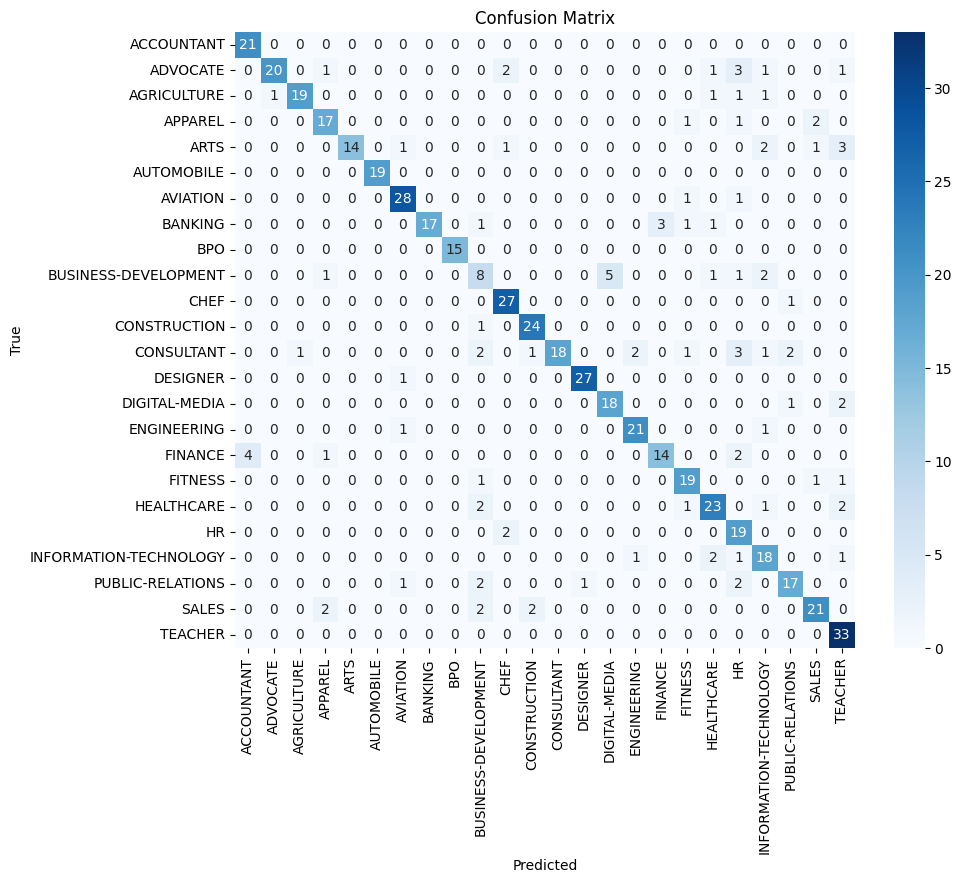

In [ ]:
from sklearn.metrics import classification_report

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)

# Step 4: Accuracy Evaluation
y_pred = rf_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test,y_pred))
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:36:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


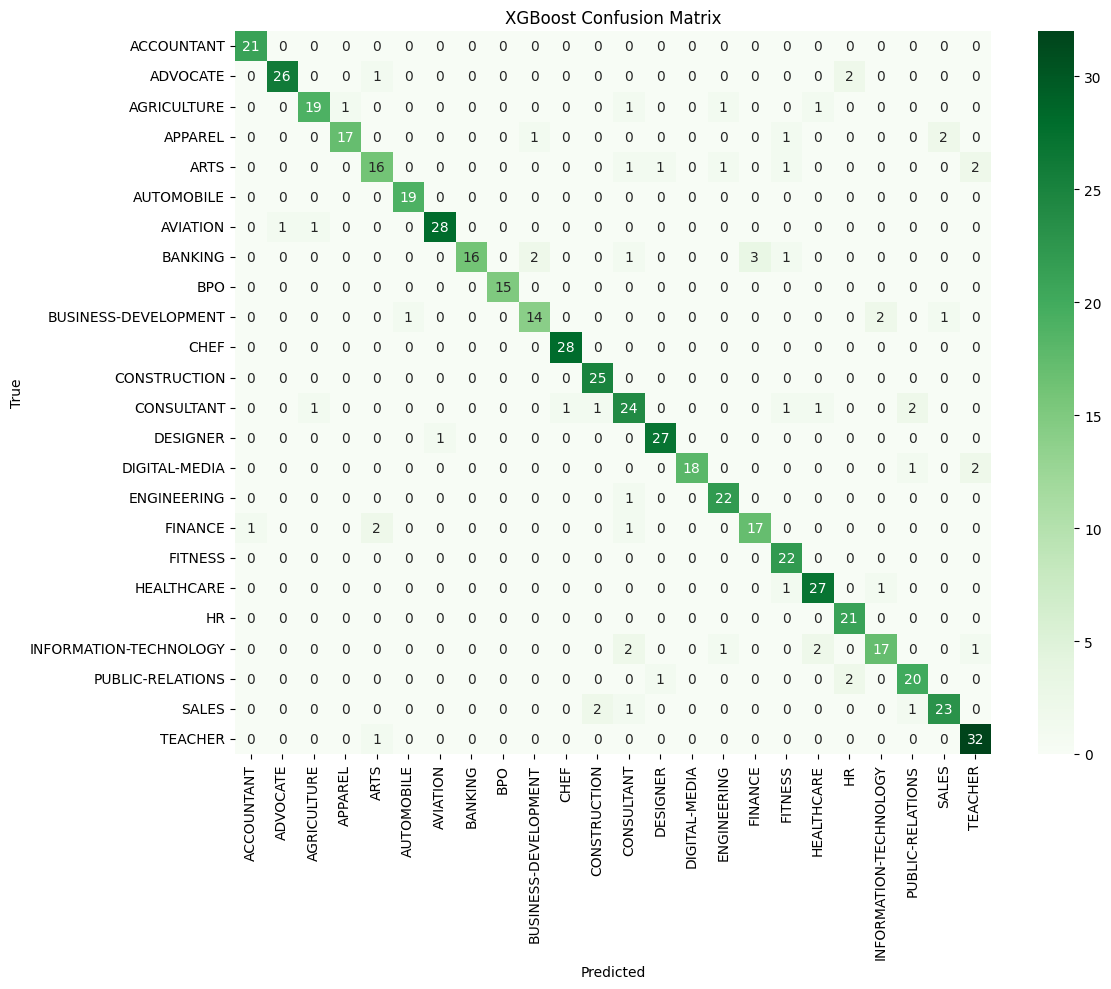


--- XGBoost Classification Report ---
                        precision    recall  f1-score   support

            ACCOUNTANT       0.95      1.00      0.98        21
              ADVOCATE       0.96      0.90      0.93        29
           AGRICULTURE       0.90      0.83      0.86        23
               APPAREL       0.94      0.81      0.87        21
                  ARTS       0.80      0.73      0.76        22
            AUTOMOBILE       0.95      1.00      0.97        19
              AVIATION       0.97      0.93      0.95        30
               BANKING       1.00      0.70      0.82        23
                   BPO       1.00      1.00      1.00        15
  BUSINESS-DEVELOPMENT       0.82      0.78      0.80        18
                  CHEF       0.97      1.00      0.98        28
          CONSTRUCTION       0.89      1.00      0.94        25
            CONSULTANT       0.75      0.77      0.76        31
              DESIGNER       0.93      0.96      0.95        28


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files


# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# Train XGBoost
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_classifier.fit(X_train_tfidf, y_train_enc)
y_pred_enc = xgb_classifier.predict(X_test_tfidf)

# Decode predictions and actual labels back to original class names
y_pred_labels = label_encoder.inverse_transform(y_pred_enc)
y_test_labels = label_encoder.inverse_transform(y_test_enc)

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)

# Classification Report (Precision, Recall, F1 Score)
report = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print Classification Report below the confusion matrix
print("\n--- XGBoost Classification Report ---")
files.download('xgboost_confusion_matrix.png')

print(report)


In [ ]:
files.download('xgboost_confusion_matrix.png')

# **Train SVM, Extra Trees, XGBoost**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:40:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


           Model  Accuracy  Precision (macro avg)  Recall (macro avg)  \
3        XGBoost     89.06                  89.27               88.82   
2  Random Forest     86.11                  87.16               86.04   
1    Extra Trees     84.03                  85.60               84.20   
0            SVM     82.81                  83.38               83.26   

   F1-score (macro avg)  
3                 88.64  
2                 85.99  
1                 84.07  
0                 82.73  


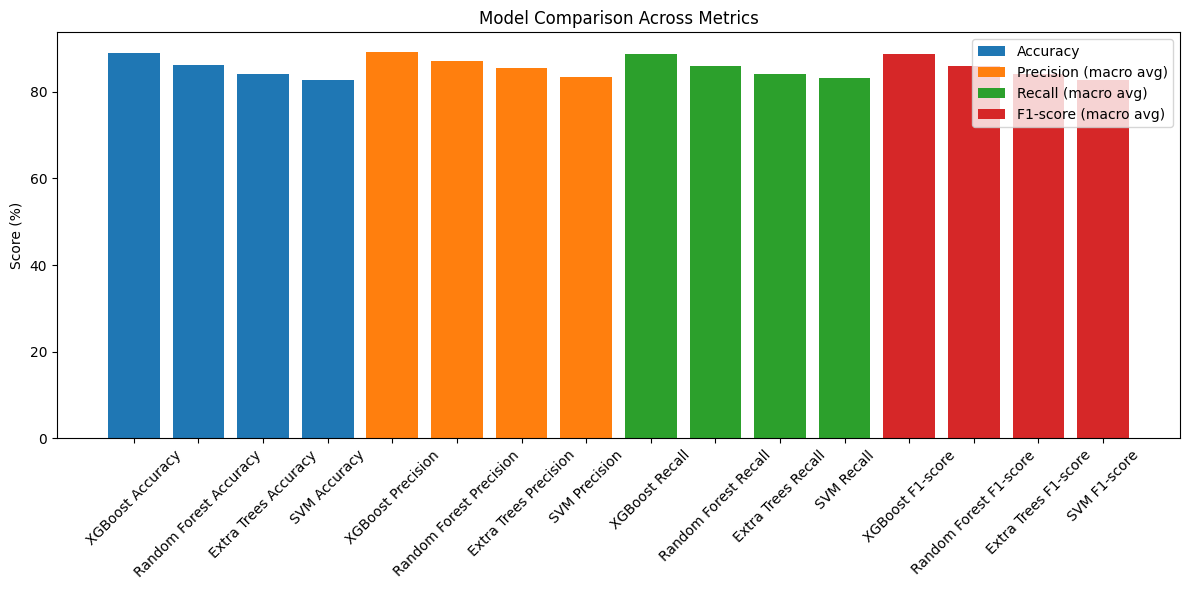

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Encode labels (for XGBoost only)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Models to compare
models = {
    'SVM': SVC(kernel='linear', random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Store results
results = []

# Train and evaluate
for name, model in models.items():
    if name == "XGBoost":
        model.fit(X_train_tfidf, y_train_encoded)
        y_pred = model.predict(X_test_tfidf)
        y_pred_labels = label_encoder.inverse_transform(y_pred)
    else:
        model.fit(X_train_tfidf, y_train)
        y_pred_labels = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred_labels) * 100
    report = classification_report(y_test, y_pred_labels, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": round(acc,2),
        "Precision (macro avg)": round(report["macro avg"]["precision"]*100,2),
        "Recall (macro avg)": round(report["macro avg"]["recall"]*100,2),
        "F1-score (macro avg)": round(report["macro avg"]["f1-score"]*100,2)
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Sort by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Display table
print(results_df)

# Side-by-side bar plot
metrics = ["Accuracy", "Precision (macro avg)", "Recall (macro avg)", "F1-score (macro avg)"]
x = results_df["Model"]

plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.bar(x + " " + metric.split()[0], results_df[metric], label=metric)

# Plot styling
plt.title("Model Comparison Across Metrics")
plt.ylabel("Score (%)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Evaluate DataFrames

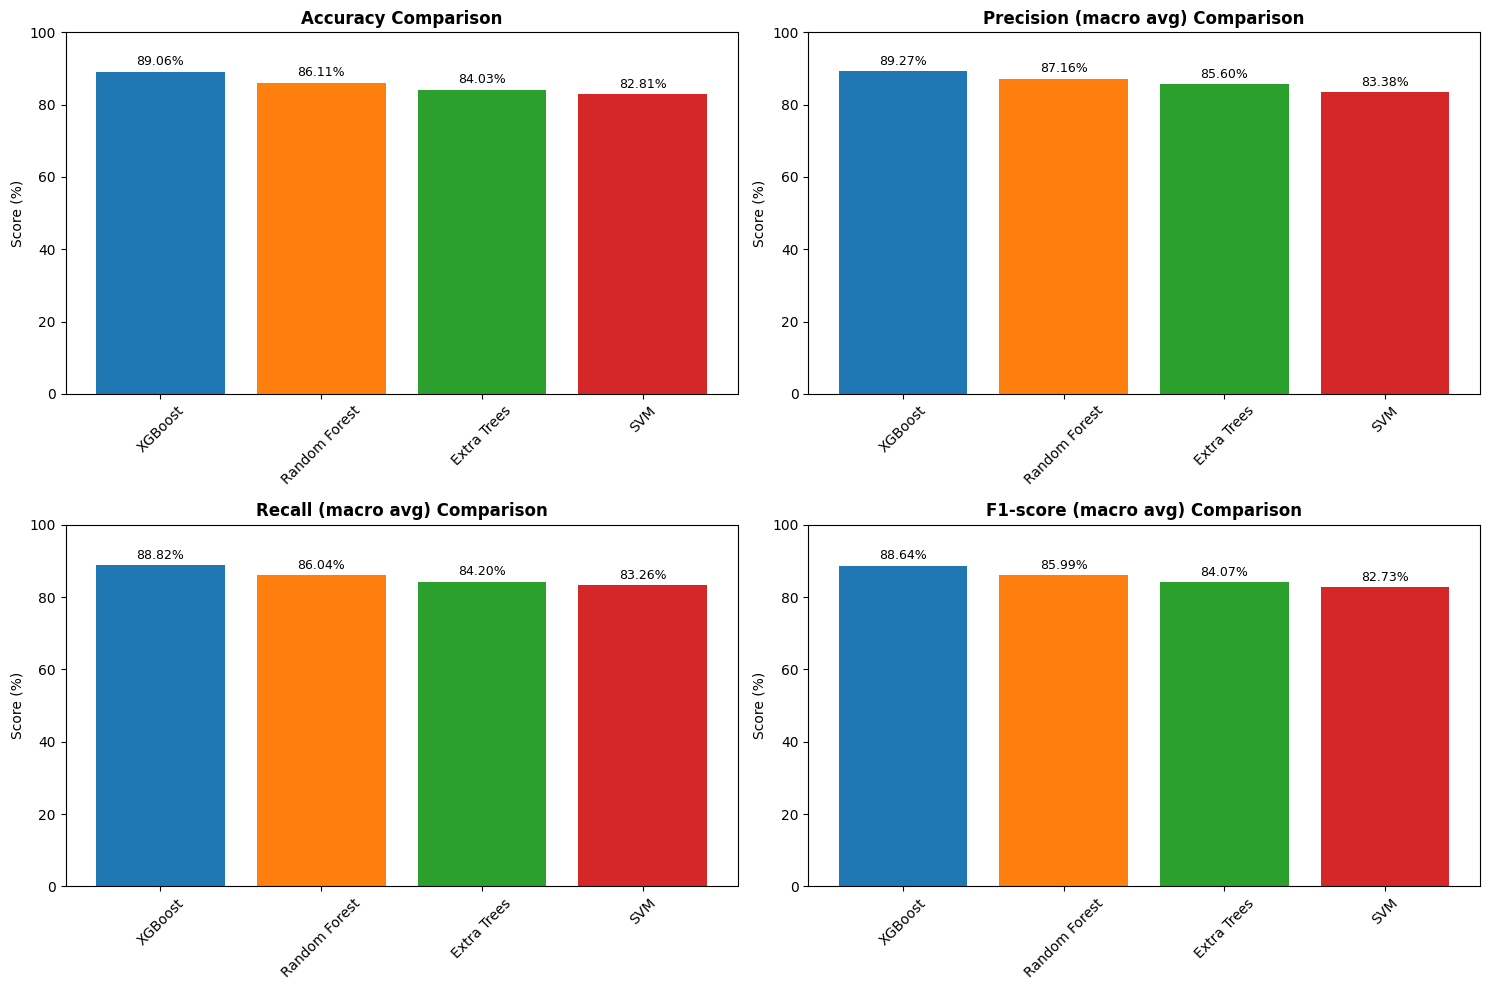

In [ ]:
metrics = ["Accuracy", "Precision (macro avg)", "Recall (macro avg)", "F1-score (macro avg)"]

plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    # Plot all models (including RF and XGBoost)
    bars = plt.bar(
        results_df["Model"],
        results_df[metric],
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Distinct colors for clarity
    )
    plt.title(f"{metric} Comparison", fontweight='bold')
    plt.ylabel("Score (%)")
    plt.ylim(0, 100)  # Ensure consistent y-axis for all plots
    plt.xticks(rotation=45)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,  # Offset for readability
            f'{height:.2f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.tight_layout()
plt.show()

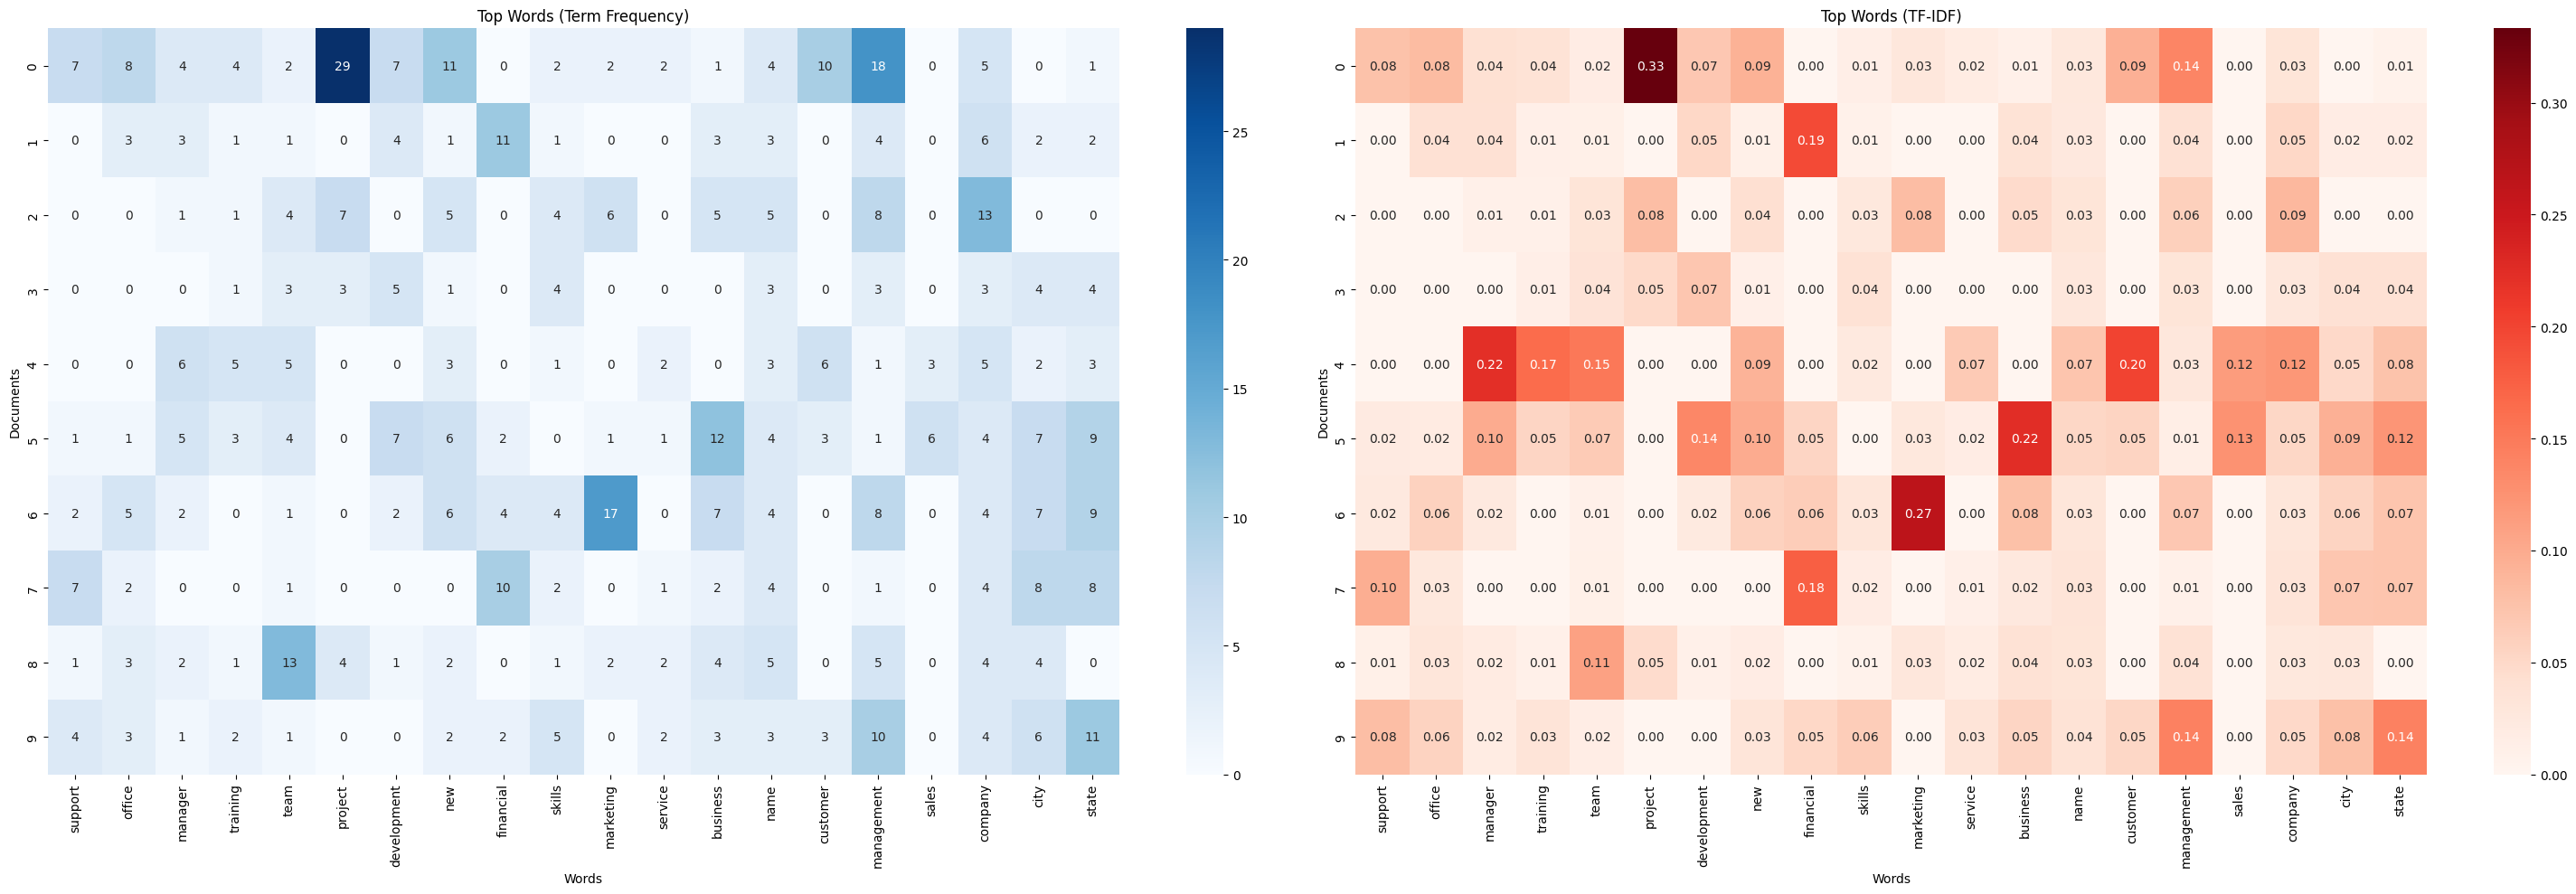

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorize
count_vectorizer = CountVectorizer(max_features=5000)
X_train_counts = count_vectorizer.fit_transform(X_train).toarray()

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

# Feature names
count_features = count_vectorizer.get_feature_names_out()
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# Determine top N TF-IDF features globally
n_samples = 10
n_top_features = 20

# Sum TF-IDF across documents to get feature importance
tfidf_sums = X_train_tfidf.sum(axis=0)
top_indices = np.argsort(tfidf_sums)[-n_top_features:]  # indices of top features

# Subset data for top features
X_counts_top = X_train_counts[:n_samples, top_indices]
X_tfidf_top = X_train_tfidf[:n_samples, top_indices]
top_feature_names = tfidf_features[top_indices]

# Plot heatmaps
plt.figure(figsize=(30, 10))

# Term Frequency Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(
    X_counts_top,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=top_feature_names,
    yticklabels=[f"{i}" for i in range(n_samples)]
)
plt.title("Top Words (Term Frequency)")
plt.xlabel("Words")
plt.ylabel("Documents")

# TF-IDF Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(
    X_tfidf_top,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    xticklabels=top_feature_names,
    yticklabels=[f"{i}" for i in range(n_samples)]
)
plt.title("Top Words (TF-IDF)")
plt.xlabel("Words")
plt.ylabel("Documents")

plt.tight_layout()
plt.show()

<ipython-input-18-1dc226493c44>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


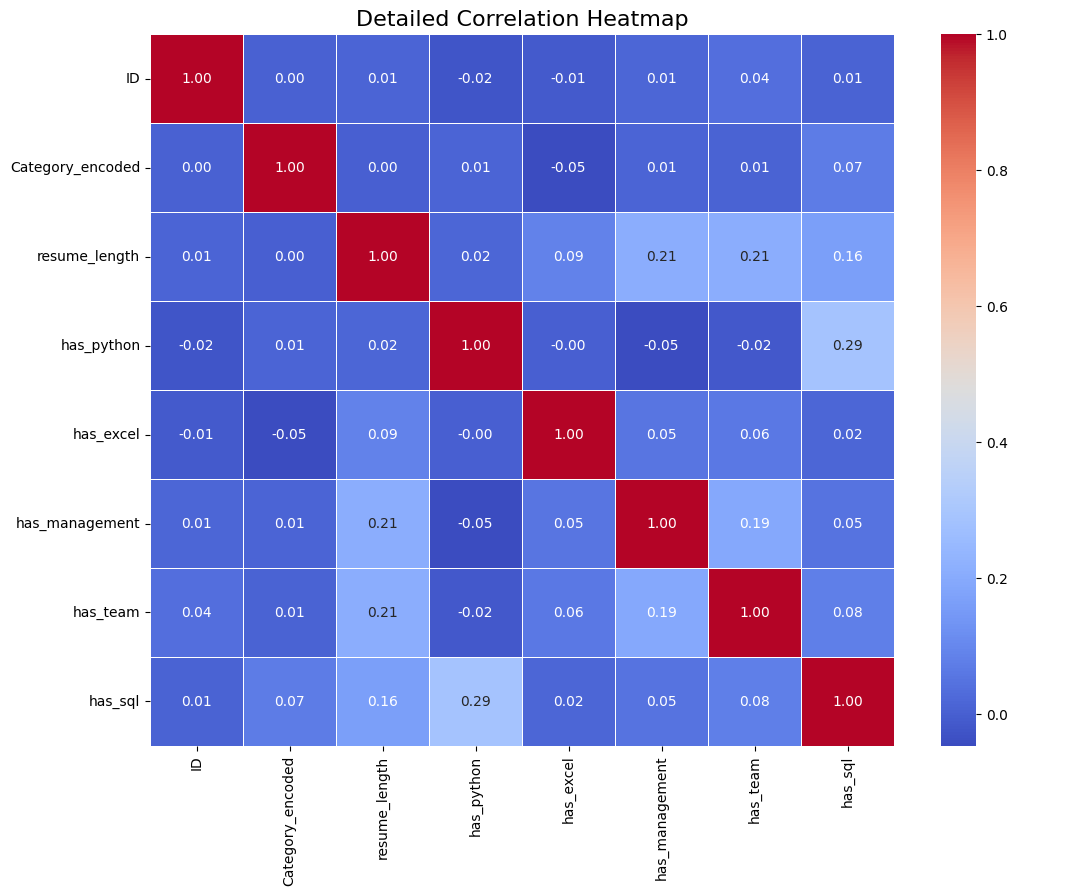

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv("clean_resume_data.csv")

# Encode category
le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])

# Handle missing values and ensure strings
df['Feature'] = df['Feature'].fillna('').astype(str)

# Create engineered features
df['resume_length'] = df['Feature'].apply(lambda x: len(x.split()))

# Add keyword indicators
keywords = ['python', 'excel', 'management', 'team', 'sql']
for kw in keywords:
    df[f'has_{kw}'] = df['Feature'].apply(lambda x: int(kw in x.lower()))

# Select numeric columns for correlation
df_numeric = df.drop(columns=['Category', 'Feature'])

# Use gridspec to control layout
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[18, 1], hspace=0.05)  # reduce hspace

# Heatmap in first row
ax0 = plt.subplot(gs[0])
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=ax0)
ax0.set_title("Detailed Correlation Heatmap", fontsize=16)

# Caption in second row
ax1 = plt.subplot(gs[1])
ax1.axis('off')
ax1.text(0.5, 0, "",
         ha='center', va='top', fontsize=12, fontweight='bold')

# Final layout adjustment
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)  # ensure minimal vertical spacing
plt.show()


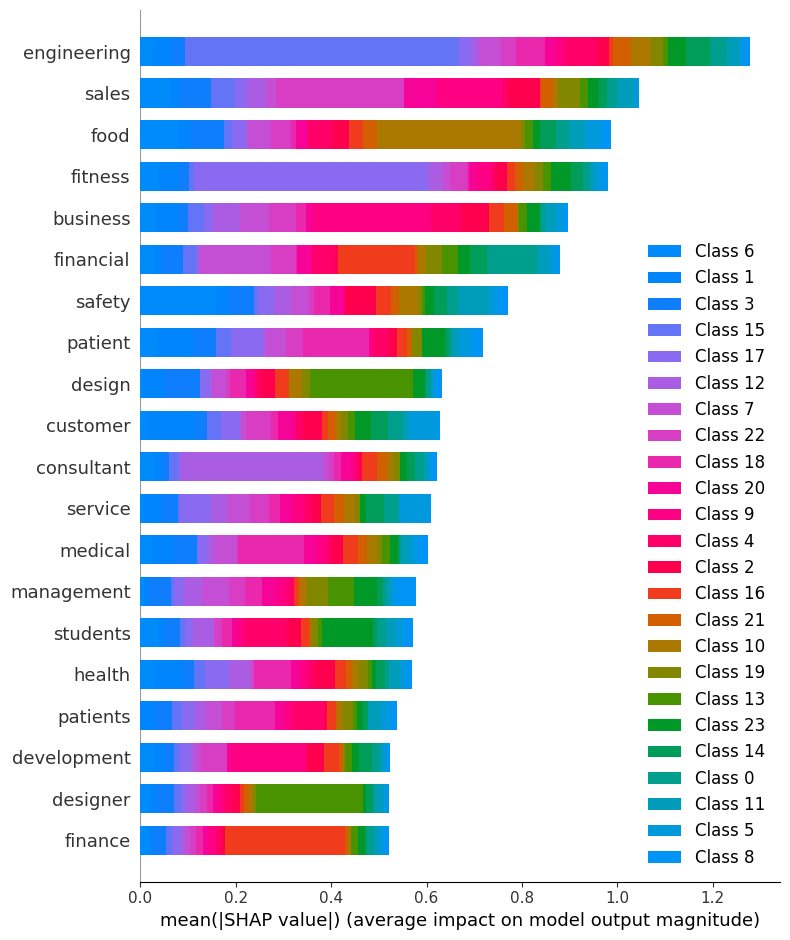

DimensionError: Length of features is not equal to the length of shap_values!

In [ ]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Prepare features and target
tfidf = TfidfVectorizer(max_features=500)  # Limit features to speed up
X_tfidf = tfidf.fit_transform(clean_df['Feature'].fillna(''))  # Fill NaN with empty strings

# Encode the labels (make sure to encode before splitting)
y = label_encoder.fit_transform(clean_df['Category'])

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# 3. Sample for SHAP (smaller subset for faster processing)
X_sample = X_train[:20].toarray()  # Use only the first 20 samples

# 4. Define a simpler model (Logistic Regression)
model = LogisticRegression(max_iter=1000, random_state=42)

# 5. Train the model
model.fit(X_train, y_train)

# 6. SHAP explanation (for Logistic Regression, using shap.Explainer)
explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)

# 7. Summary plot
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=tfidf.get_feature_names_out(),
    show=False
)
plt.tight_layout()
plt.show()

# Example usage for a specific sample (e.g., sample 0):
predicted_class = model.predict(X_sample)[0]
shap.plots.force(
    explainer.expected_value[predicted_class],  # Class-specific base value
    shap_values.values[0][predicted_class],     # Class-specific SHAP values
    features=X_sample[0],
    feature_names=tfidf.get_feature_names_out()
)


Model Performance (k-Fold Cross-Validation):

SVM (Linear Kernel):
  Accuracy: 65.3600
  Precision: 65.4400
  Recall: 65.3600
  F1-Score: 64.5700

Random Forest:
  Accuracy: 68.7500
  Precision: 66.9800
  Recall: 68.7500
  F1-Score: 66.3000

Extra Trees:
  Accuracy: 64.0400
  Precision: 63.3800
  Recall: 64.0400
  F1-Score: 61.4000

XGBoost:
  Accuracy: 72.6900
  Precision: 71.8000
  Recall: 72.6900
  F1-Score: 71.7600


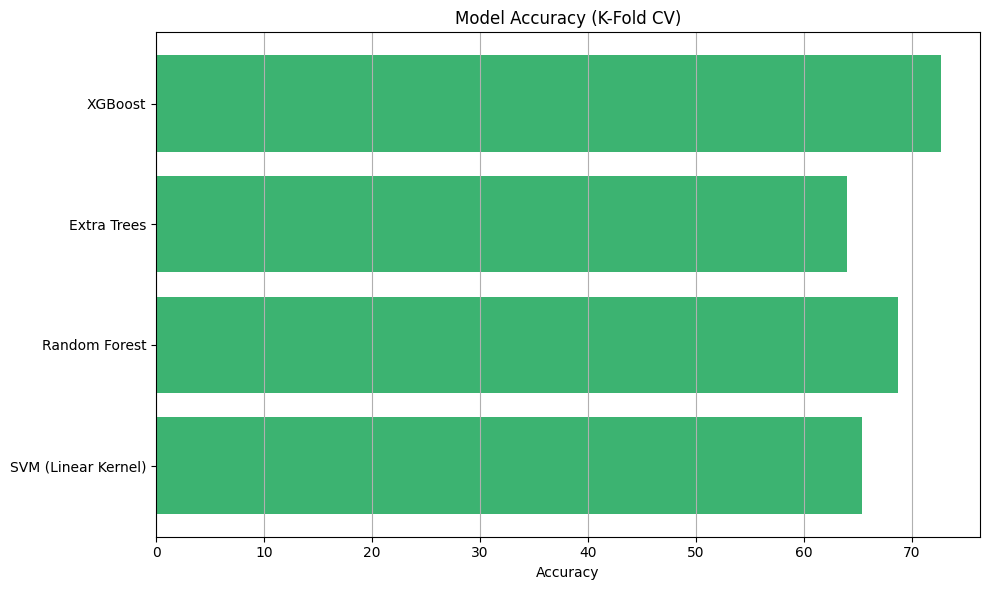

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

# ------------------ LOAD DATA ------------------
df = pd.read_csv("clean_resume_data.csv")  # Update path if needed
df.dropna(subset=["Feature"], inplace=True)

X = df["Feature"]
y = df["Category"]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ------------------ DEFINE MODELS ------------------
models = {
    "SVM (Linear Kernel)": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# ------------------ K-FOLD CV ------------------
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    pipeline = make_pipeline(
        TfidfVectorizer(max_features=1000),
        model
    )

    y_preds = cross_val_predict(pipeline, X, y_encoded, cv=kfold)

    results[name] = {
        "Accuracy": round(accuracy_score(y_encoded, y_preds)*100,2),
        "Precision": round(precision_score(y_encoded, y_preds, average='weighted')*100,2),
        "Recall": round(recall_score(y_encoded, y_preds, average='weighted')*100,2),
        "F1-Score": round(f1_score(y_encoded, y_preds, average='weighted')*100,2)
    }

# ------------------ PRINT RESULTS ------------------
print("\nModel Performance (k-Fold Cross-Validation):")
for model_name, scores in results.items():
    print(f"\n{model_name}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.4f}")

# ------------------ OPTIONAL: PLOT ACCURACY ------------------
names = list(results.keys())
accuracies = [results[name]['Accuracy'] for name in names]

plt.figure(figsize=(10, 6))
plt.barh(names, accuracies, color='mediumseagreen')
plt.xlabel("Accuracy")
plt.title("Model Accuracy (K-Fold CV)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# Predictive System

In [ ]:
# Clean resume
import re
def cleanResume(txt):
    cleanText = re.sub('http\S+\s', ' ', txt)
    cleanText = re.sub('RT|cc', ' ', cleanText)
    cleanText = re.sub('#\S+\s', ' ', cleanText)
    cleanText = re.sub('@\S+', '  ', cleanText)
    cleanText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleanText)
    cleanText = re.sub(r'[^\x00-\x7f]', ' ', cleanText)
    cleanText = re.sub('\s+', ' ', cleanText)
    return cleanText


# Prediction and Category Name
def predict_category(resume_text):
    resume_text= cleanResume(resume_text)
    resume_tfidf = tfidf_vectorizer.transform([resume_text])
    predicted_category = rf_classifier.predict(resume_tfidf)[0]
    return predicted_category